# Анализ e-commerce проекта

Импортируем библиотеки и определим графические параметры

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Настройка графики

setting = sns.set(
           font_scale=2,
           style="whitegrid",
           rc={'figure.figsize':(20, 7)}
)

In [3]:
# Список соответствия публичных ключей и исходных датафреймов

pb_keys = {
           'df_customers':   'https://disk.yandex.ru/d/QXrVDUoQvFhIcg',
           'df_orders':      'https://disk.yandex.ru/d/0zWmh1bYP6REbw', 
           'df_order_items': 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg', 
          }

In [4]:
# Функция считывания csv-файла по API 

def read_yadisk_csv(public_key: str) -> pd.DataFrame():

    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response  = requests.get(final_url) 
    download_url = response.json()['href']
    df = pd.read_csv(download_url)
    datetime_columns = [label for label in df.columns if ('time' in label) or ('date' in label) or ('approved' in label)]
    df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)
    
    return df

#   БЛОК 1. <u> EDA-анализ<u> 

Получение основной информации о датафреймах и изучение особенностей данных в них.
    
## Описание исходных данных: 

- **df_customers** - таблица с уникальными идентификаторами и информацией о клиентах:

    `customer_id` - позаказный идентификатор пользователя; <br/>
    `customer_unique_id` - уникальный идентификатор пользователя (аналог номера паспорта); <br/>
    `customer_zip_code_prefix` - почтовый индекс пользователя;<br/>
    `customer_city` - город доставки пользователя;<br/> 
    `customer_state` - штат доставки пользователя.<br/> 


- **df_orders** - таблица с информацией о заказах:

    `order_id` - уникальный идентификатор заказа (номер чека);<br/>
    `customer_id` - позаказный идентификатор пользователя;<br/>
    `order_status` - статус заказа;<br/>
    `order_purchase_timestamp` - время создания заказа;<br/> 
    `order_approved_at` - время подтверждения оплаты заказа;<br/> 
    `order_delivered_carrier_date` - время передачи заказа в логистическую службу;<br/>
    `order_delivered_customer_date` - время доставки заказа;<br/>
    `order_estimated_delivery_date` - обещанная дата доставки;<br/>


- **df_order_items** - таблица с информацией о товарных позициях, входящих в заказ:

    `order_id` - уникальный идентификатор заказа (номер чека);<br/> 
    `order_item_id` - идентификатор товара внутри одного заказа;<br/> 
    `product_id` - ид товара (аналог штрихкода);<br/>
    `seller_id` - ид производителя товара;<br/>
    `shipping_limit_date` - максимальная дата доставки продавцом для передачи заказа партнеру по логистике;<br/>
    `price` - цена за единицу товара;<br/>
    `freight_value` - вес товара.
    
## 1.1 Данные о клиентах (df_customers)

In [5]:
df_customers = read_yadisk_csv(pb_keys['df_customers'])
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
# Размер
df_customers.shape

(99441, 5)

In [7]:
# Проверка на уникальность
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [8]:
# Наличие полных дубликатов
df_customers.duplicated().sum()

0

In [9]:
# Проверка NaN
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [10]:
# Типы значений
df_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [11]:
# Короткое описание (повторная проверка)
df_customers.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)

In [12]:
# Проверка на дубликаты id пользователей
df_customers.customer_unique_id.duplicated().sum()

3345

In [13]:
# Проверка на дубликаты позаказных id пользователей
df_customers.customer_id.duplicated().sum()

0

In [14]:
# ПРИМЕР
df_customers[df_customers.customer_unique_id == 'b6c083700ca8c135ba9f0f132930d4e8']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
132,f7c5afab273b47ab517e096e0219b932,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP
679,c57b4b6f3719475543b721e720a526ad,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP


**Вывод**: позаказный номер `customer_id` уникален, а `customer_unique_id` дублируется (в данном DF он неуникален)

## 1.2 Данные о заказах (df_orders)

In [15]:
df_orders = read_yadisk_csv(pb_keys['df_orders'])
df_orders[5:10]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23


In [16]:
df_orders.shape

(99441, 8)

In [17]:
df_orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [18]:
df_orders.duplicated().sum()

0

In [19]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [20]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [21]:
df_orders.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)

In [22]:
df_orders.order_id.duplicated().sum()

0

In [23]:
df_orders.customer_id.duplicated().sum()

0

In [24]:
# Cтатусы заказа
df_orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

**Вывод**: идентификаторы заказов `order_id` и позаказные номера пользователей `customer_id` уникальны. <br/> Следовательно, при изменении статуса заказа не создается новая запись, а редактируется существующая, значит каждый статус характеризует конечный этап на котором находится заказ в данный момент.

## 1.3 Данные о товарах в заказах (df_order_items)

In [25]:
df_order_items = read_yadisk_csv(pb_keys['df_order_items'])
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
df_order_items.shape

(112650, 7)

In [27]:
df_order_items.duplicated().sum()

0

In [28]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [29]:
df_order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [30]:
df_order_items.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)

In [31]:
df_order_items.order_id.duplicated().sum()

13984

In [32]:
# Максимальное количество товаров в заказе
df_order_items.order_item_id.max()

21

In [33]:
# Количество уникальных товаров
df_order_items.product_id.nunique()

32951

**Вывод**: идентификаторы заказов `order_id` и идентификаторы товаров `product_id` неуникальны.

## 1.4 Пример структуры данных (для одного заказа)

In [34]:
# Данные о товарах в заказе
df_order_items[df_order_items.order_id == 'fb3cf8c9eb2412b0edc0a00a8f43a869']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
110566,fb3cf8c9eb2412b0edc0a00a8f43a869,1,09b0d15a8cc9a84e7af7e0225f67dc45,1025f0e2d44d7041d6cf58b6550e0bfa,2018-06-06 14:31:55,67.00,24.65
110567,fb3cf8c9eb2412b0edc0a00a8f43a869,2,09b0d15a8cc9a84e7af7e0225f67dc45,1025f0e2d44d7041d6cf58b6550e0bfa,2018-06-06 14:31:55,67.00,24.65
110568,fb3cf8c9eb2412b0edc0a00a8f43a869,3,066cc58255ee9ccb3e6da9d3edd02a7e,903037660cf848a717166eb7a06d616e,2018-06-07 14:31:55,39.99,8.22
110569,fb3cf8c9eb2412b0edc0a00a8f43a869,4,09b0d15a8cc9a84e7af7e0225f67dc45,1025f0e2d44d7041d6cf58b6550e0bfa,2018-06-06 14:31:55,67.00,24.65
110570,fb3cf8c9eb2412b0edc0a00a8f43a869,5,4cceacaeb21aa22aa51b4c724de3758d,157c3e4b42f81ac4a44e8b1ca2fe9876,2018-06-06 14:31:55,90.00,8.22


In [35]:
# Данные о заказе
df_orders[df_orders.order_id == 'fb3cf8c9eb2412b0edc0a00a8f43a869']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
12332,fb3cf8c9eb2412b0edc0a00a8f43a869,94595ccee21b11325952776b516a0345,delivered,2018-05-29 14:07:25,2018-05-29 14:39:27,2018-05-29 13:58:00,2018-06-05 21:46:32,2018-07-20


In [36]:
# Данные о клиенте, совершившем заказ
df_customers[df_customers.customer_id == '94595ccee21b11325952776b516a0345']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
7009,94595ccee21b11325952776b516a0345,46d42c60487c64480765a312ee6172c8,23063,rio de janeiro,RJ


#  БЛОК 2. <u> Выполнение аналитических задач (ad-hoc)<u> 
    
## 2.1. Определить количество пользователей, которые совершили одну покупку.
    
### Сформулируем и обоснуем определение покупки:

**Покупка** - любой заказ у которого есть информация о времени подтверждения оплаты (`order_approved_at`) и 
который не был отменен клиентом на любом этапе. То есть покупками считаться не будут:

1) Все заказы с отсутствием информации о факте оплаты (`order_approved_at`)<br/>
2) Все заказы отмененные клиентом (`canceled`) даже после оплаты (`order_approved_at`) т.к. осуществляется возврат средств ->
   отмена покупки.


In [37]:
# Статусы заказов без информации о факте оплаты (order_approved_at)

df_orders[df_orders.order_approved_at.isna()].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

In [38]:
# Количество заказов без информации о факте оплаты (order_approved_at)

df_orders[df_orders.order_approved_at.isna()].order_status.count()

160

In [39]:
# Количество заказов, отмененных после оплаты (canceled)

df_orders[(df_orders.order_approved_at.notna()) & (df_orders.order_status == 'canceled')].order_id.count()

484

**Примечание:** 
 - Заметим, что информация о факте оплаты заказа отсутствует у заказов со статусом `delivered`, что вероятно обусловлено сбоем в системе учета оплаты или статусов заказов, поэтому такие заказы будут считаться аномалией и при анализе учитываться не будут.
 - Из анализа будут исключены 160 + 484 = 644 заказа, не соответсвующие заданному определению покупки.

In [40]:
# Данные об ОПЛАЧЕННЫХ заказах и клиентах

df_orders_buy = df_orders[(df_orders.order_approved_at.notna()) & (df_orders.order_status != 'canceled')]

df_orders_customers_buy = df_orders_buy.merge(df_customers, on='customer_id')
df_orders_customers_buy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
98792,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
98793,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
98794,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
98795,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [41]:
# Проверка
df_orders.shape[0] - df_orders_customers_buy.shape[0] == 644

True

In [42]:
# №1 Сколько у нас пользователей, которые совершили покупку только один раз?

one_buy_customers = df_orders_customers_buy \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'count_orders'}) \
    .query('count_orders == 1')

print(f'Количество пользователей совершивших одну покупку = {one_buy_customers.customer_unique_id.count()}')

Количество пользователей совершивших одну покупку = 92621


## 2.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

### Сформулируем и обоснуем определение недоставленного заказа:

**Недоставленный заказ** - заказ с отсутствием информации о времени доставки заказа (`order_delivered_customer_date`) или любой отмененный заказ (`canceled`) -> таким образом, мы учтем случаи отмены заказа при получении, что также считается недоставленным заказом.

Интерпретируем статусы недоставленных заказов следующим образом: 
 - `shipped` ==    заказ отгружен со склада и потерян партнером по логистике
 - `unavailable` == заказ недоступен т.к. товара нет в наличии
 - `processing`== заказ задерживается в процессе сборки
 - `approved`== заказ подтвержден, но не передан на сборку 
 - `created`== заказ создан покупателем ошибочно
 - `canceled` == заказ отменен покупателем
 - `invoiced` == заказ не оплачен покупателем.

In [43]:
# Количество недоставленных заказов (детализация по статусам)

df_orders[df_orders.order_delivered_customer_date.isna() | (df_orders.order_status == 'canceled')] \
        .order_status \
        .value_counts() \
        .to_frame()

,order_status
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
delivered,8
created,5
approved,2


**Примечание:** В полученной таблице есть 8 доставленных заказов (delivered) у которых отсутствует
информация о времени доставки (`order_delivered_customer_date`). Данные заказы будут считаться аномалией и учитываться при анализе не будут т.к. они очевидно являются следствием сбоя либо в статусах заказов, либо в системе учета времени доставки (неизвестно доставлены они или нет).

In [44]:
# Данные о всех заказах и клиентах

df_orders_customers = df_orders.merge(df_customers, on='customer_id')
df_orders_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [45]:
# Данные о недоставленных заказах (без учета выявленной аномалии)

undelivered_orders = df_orders_customers[(df_orders_customers.order_delivered_customer_date.isna()) & \
                                         (df_orders_customers.order_status !='delivered') |
                                         (df_orders_customers.order_status == 'canceled')] \
                                         .reset_index(drop=True)
undelivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS
1,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP
2,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,c7f8d7b1fffc946d7069574f74c39f4e,88140,santo amaro da imperatriz,SC
3,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP
4,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,528b011eb7fab3d59c336cc7248eed3a,38600,paracatu,MG
...,...,...,...,...,...,...,...,...,...,...,...,...
2958,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP
2959,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06,965191786b70912f793e4a777fd623cd,13050,campinas,SP
2960,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,d05c44a138277ad325d915c6b7ccbcdf,5344,sao paulo,SP
2961,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ


In [46]:
print('Диапозон дат создания недоставленных заказов\n')
print('Начало:', undelivered_orders.order_purchase_timestamp.min())
print('Конец: ', undelivered_orders.order_purchase_timestamp.max())

Диапозон дат создания недоставленных заказов

Начало: 2016-09-04 21:15:19
Конец:  2018-10-17 17:30:18



**Примечание**: в диапозоне дат первый месяц начинается не сначала, однако он почти не искажает общую картину (не достает всего 4 дня до полного месяца), в свою очередь последний месяц в диапозоне дат не учитывает половину дней, поэтому по нему нельзя судить о количестве недоставленных товаров в этом месяце => **последний месяц в анализе учитываться не будет**   (`order_purchase_timestamp < '2018-10-01'`)


In [47]:
# Определим количество недоставленных заказов на каждый месяц каждого года (по дате создания заказа)

undelivered_orders['year_month'] = undelivered_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

md_count_orders = undelivered_orders \
                    .query("order_purchase_timestamp < '2018-10-01'") \
                    .groupby('year_month') \
                    .agg({'order_id': 'count'}) \
                    .rename(columns = {'order_id':'count_orders'}) \
                    .apply(np.median)

**Примечание**: использовали медианное среднее
  поскольку данные имеют несколько сильных выбросов (первый и последний месяц).


In [48]:
print(f'Среднее количество недоставленных заказов в месяц: {md_count_orders[0]}')

Среднее количество недоставленных заказов в месяц: 136.0


**Примечание:** Теперь определим заказы с каким статусом в среднем чаще всего не доставляются ежемесячно.

In [49]:
# Количество недоставленных заказов каждого статуса на каждый месяц

count_orders_undelivered = undelivered_orders \
                  .pivot_table(index='order_status', columns='year_month', values='order_id', aggfunc='nunique') \
                  .fillna(0)
count_orders_undelivered

year_month,2016-09,2016-10,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
order_status,,,,,,,,,,,,,,,,,,,,,
approved,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
canceled,2.0,24.0,3.0,17.0,33.0,18.0,29.0,16.0,28.0,27.0,...,34.0,73.0,26.0,15.0,24.0,18.0,41.0,84.0,15.0,4.0
created,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
invoiced,0.0,18.0,12.0,11.0,3.0,14.0,16.0,11.0,7.0,20.0,...,15.0,6.0,23.0,14.0,24.0,3.0,13.0,23.0,0.0,0.0
processing,0.0,2.0,9.0,32.0,23.0,10.0,23.0,12.0,11.0,18.0,...,29.0,6.0,9.0,8.0,6.0,0.0,1.0,0.0,0.0,0.0
shipped,1.0,8.0,16.0,21.0,45.0,49.0,55.0,47.0,56.0,41.0,...,74.0,57.0,133.0,99.0,54.0,43.0,60.0,47.0,1.0,0.0
unavailable,0.0,7.0,10.0,45.0,32.0,9.0,31.0,24.0,52.0,32.0,...,48.0,30.0,17.0,5.0,16.0,4.0,18.0,7.0,0.0,0.0


In [50]:
# Определим среднее количество недоставленных заказов каждого статуса на каждый месяц

avg_orders_undelivered = count_orders_undelivered.apply(np.mean, axis=1).to_frame() \
                                    .rename(columns={0:'avg_count_orders'}) \
                                    .sort_values('avg_count_orders', ascending=False) \
                                    .reset_index() \
                                    .round(2)
avg_orders_undelivered

,order_status,avg_count_orders
0,shipped,46.12
1,canceled,26.04
2,unavailable,25.38
3,invoiced,13.08
4,processing,12.54
5,created,0.21
6,approved,0.08


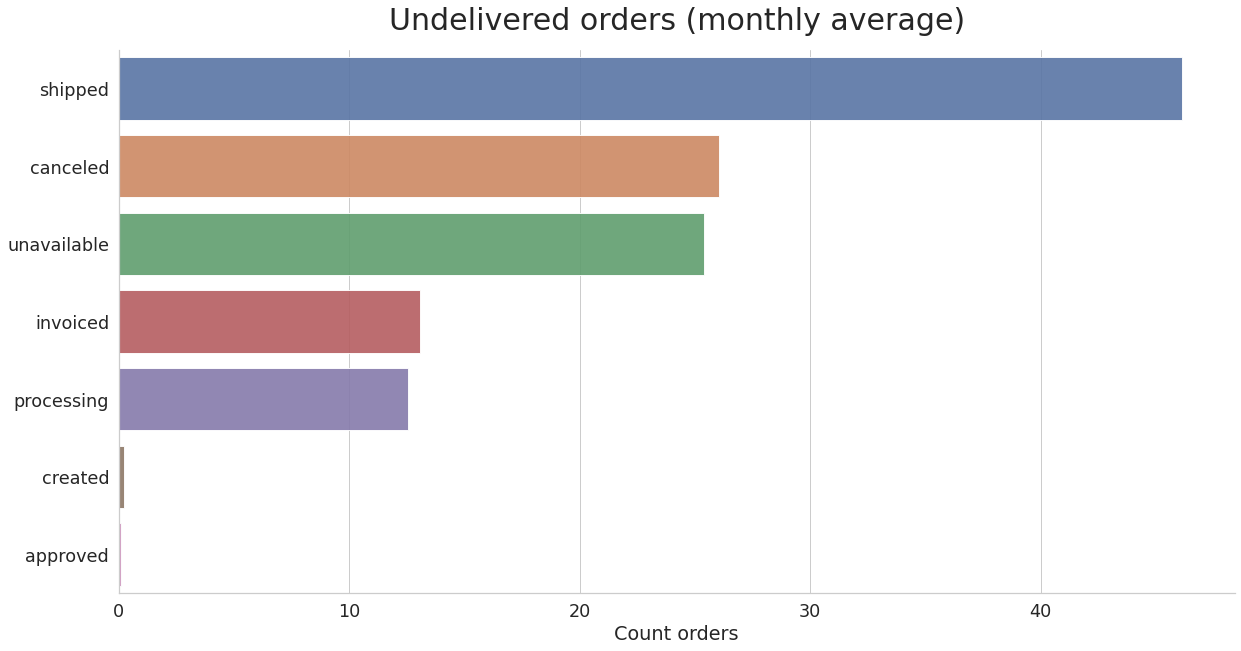

In [51]:
# Визуализация cреднего количества недоставленных заказов в месяц (с детализацией по статусам)

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6, style='whitegrid')

ax = sns.barplot(data=avg_orders_undelivered, y='order_status', x='avg_count_orders', alpha=0.9)
ax.set(xlabel='Сount orders', ylabel='')
plt.title('Undelivered orders (monthly average)', pad=20, fontsize=30)

sns.despine()
plt.show()

**Примечание:** Соотнесем статусы с зонами ответственности для того, чтобы определить по чьей вине не доставляется наибольший процент заказов.

In [52]:
# Распределение статусов по зонам ответсвенности

seller_error   = ['processing', 'approved', 'unavailable']
customer_error = ['created', 'canceled', 'invoiced']
logistic_error = ['shipped']

In [53]:
def to_category(df):
    error_lst = []
    for i in range(len(df)):
        if df.order_status[i] in seller_error:
            error_lst.append('Seller')
        elif df.order_status[i] in customer_error:
            error_lst.append('Customer')
        else:
            error_lst.append('Logistic partner')
    return df.assign(subject = pd.Series(error_lst))

In [54]:
# Среднее количество недоставленных заказов в месяц (Детализацией по зонам ответственности)

distr_category = to_category(avg_orders_undelivered) \
    .groupby('subject', as_index=False) \
    .agg({'avg_count_orders':'sum'}) \
    .sort_values('avg_count_orders', ascending=False) \
    .reset_index(drop=True)
distr_category

,subject,avg_count_orders
0,Logistic partner,46.12
1,Customer,39.33
2,Seller,38.00


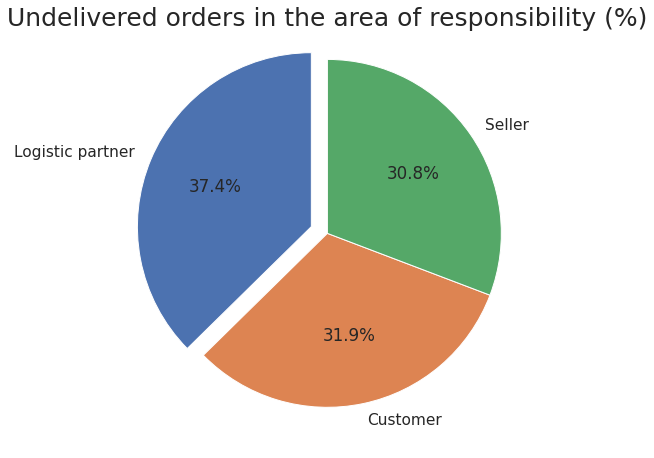

In [55]:
# Визуализация cреднего количества недоставленных заказов в месяц (Детализация по зонам ответсвенности)

sns.set(font_scale=1.4)
plt.figure(figsize=(15, 8))
plt.pie(data=distr_category, 
        x='avg_count_orders', 
        startangle=90, 
        labels='subject', 
        autopct='%1.1f%%', 
        explode=(0.1, 0.0, 0.0))
plt.title('Undelivered orders in the area of responsibility (%)', pad = -10, fontsize=25)
plt.show()

**Вывод:** В среднем ежемесячно не доставляется 136 заказов, причем большая часть заказов (37,4 %) не доставляется по вине партнера по логистике. Следовательно, оптимальным вариантом снижения количества недоставленных заказов видится смена партнера по логистике на более надежного.

## 2.3 Определить по каждому товару день недели в который он чаще всего покупается.

Проананализируем поведение покупателей и оценим популярность продаж товаров по дням недели

In [56]:
# Объединим ОПЛАЧЕННЫЕ заказы с информацией о товарах в них

df_product_buy = df_orders_buy.merge(df_order_items, on='order_id', how='left')
df_product_buy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112694,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112695,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112696,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112697,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [57]:
# Уникальное количество товаров не совпадает

df_order_items.product_id.nunique() - df_product_buy.product_id.nunique()

219

**Примечание**: часть уникальных товаров из `df_order_items` не попала в датафрейм `df_product_buy`, так как они находятся в неоплаченных заказах.

In [58]:
# Определим день недели в который была совершена покупка товара

df_product_buy['week_day'] = df_product_buy.order_purchase_timestamp.dt.day_name()
df_product_buy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,week_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112694,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,Tuesday
112695,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,Sunday
112696,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday
112697,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday


In [59]:
# Найдем количество покупок для каждого товара по дням недели

count_buy_product = df_product_buy \
    .groupby(['product_id', 'week_day'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'count_buy'})

count_buy_product.head()

,product_id,week_day,count_buy
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [60]:
# Определим дни недели в которые каждый товар чаще всего покупали

product_weekday_buy = count_buy_product \
    .set_index('week_day') \
    .groupby('product_id') \
    .apply(lambda x: x[x.count_buy == x.count_buy.max()].index.to_list()) \
    .to_frame() \
    .rename(columns={0:'max_buy_day'}) \
    .reset_index()

product_weekday_buy

,product_id,max_buy_day
0,00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,[Thursday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Tuesday]
...,...,...
32727,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32728,fff81cc3158d2725c0655ab9ba0f712c,[Monday]
32729,fff9553ac224cec9d15d49f5a263411f,[Friday]
32730,fffdb2d0ec8d6a61f0a0a0db3f25b441,[Tuesday]


**Примечание**: в таблице выше содержится информация о днях в которые каждый товар чаще всего покупали, 
причем для некоторых товаров таких дней может быть несколько. Ниже приведен пример такого товара.

In [61]:
# (ПРИМЕР) У данного товара несколько популярных дней его покупки

count_buy_product[count_buy_product.product_id == '00faa46f36261af8bbf3a4d37fa4841b'] \
                .sort_values('count_buy', ascending=False) \
                .head(3)

,product_id,week_day,count_buy
200,00faa46f36261af8bbf3a4d37fa4841b,Saturday,3
202,00faa46f36261af8bbf3a4d37fa4841b,Tuesday,3
198,00faa46f36261af8bbf3a4d37fa4841b,Friday,1


In [62]:
# (ПРИМЕР) Наша таблица учла особенность данного товара и представила эти дни в виде списка 

product_weekday_buy.reset_index().query("product_id == '00faa46f36261af8bbf3a4d37fa4841b'")

,index,product_id,max_buy_day
114,114,00faa46f36261af8bbf3a4d37fa4841b,"[Saturday, Tuesday]"


### Дополнительно: посмотрим количество купленных товаров по дням недели.

In [63]:
product_weekday_plot = count_buy_product.groupby('week_day', as_index=False).agg({'count_buy':'sum'})

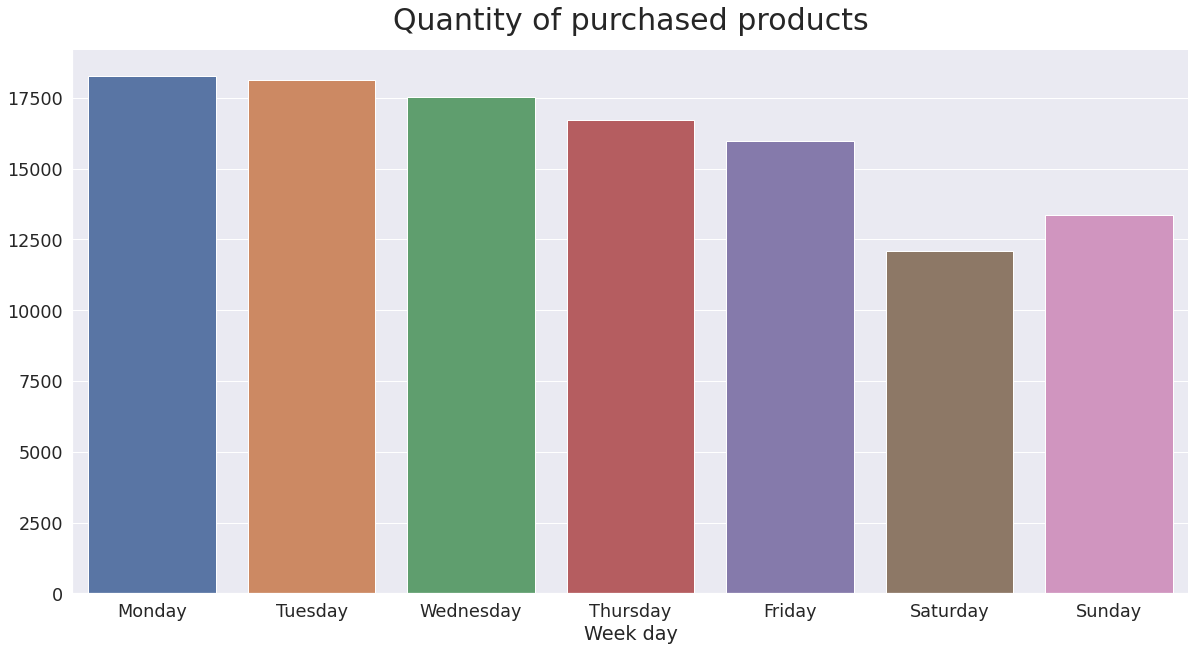

In [65]:
# Визуализация количества купленных товаров по дням недели

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)

ax = sns.barplot(data=product_weekday_plot, 
            x='week_day', 
            y='count_buy', 
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set(xlabel='Week day', ylabel='')
plt.title('Quantity of purchased products', pad=20, fontsize=30)

sns.despine()
plt.show()

**Примечание:** 
- Пользователи активнее совершают покупки товаров в начале каждой недели. 
- В рабочие дни покупается большее число товаров в сравнении с выходными.
- Максимальное и минимальное количество купленных товаров отличается внутри недели в 1.5 раза

Проведенное исследование может быть полезно для определения того в какой день недели и по какому товару маркетинговые мероприятия окажутся наиболее востребованы пользователями.

## 2.4 Определить среднее количество покупок у каждого пользователя в неделю (по месяцам).

При анализе будем учитывать следующие особенности:
- Внутри месяца может быть нецелое количество недель;
- Данные о первом и последнем месяце могут быть неполными.

In [66]:
# Рассмотрим ранее созданный датафрейм с информацией об ОПЛАЧЕННЫХ заказах и клиентах

df_orders_customers_buy_copy = df_orders_customers_buy.copy()

df_orders_customers_buy_copy['year'] = df_orders_customers_buy_copy.order_purchase_timestamp.dt.year
df_orders_customers_buy_copy['month'] = df_orders_customers_buy_copy.order_purchase_timestamp.dt.month_name()
df_orders_customers_buy_copy['week_in_month'] = df_orders_customers_buy_copy.order_purchase_timestamp.dt.days_in_month / 7 

df_orders_customers_buy_copy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year,month,week_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,October,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,July,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,August,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,November,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,February,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98792,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017,March,4.428571
98793,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018,February,4.000000
98794,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017,August,4.428571
98795,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018,January,4.428571


**Примечание**: в качестве даты покупки будем считать дату создания заказа (`order_purchase_timestamp`)

In [67]:
print('Диапозон дат создания оплаченных заказов\n')
print('Начало:', df_orders_customers_buy_copy.order_purchase_timestamp.min())
print('Конец: ', df_orders_customers_buy_copy.order_purchase_timestamp.max())

Диапозон дат создания оплаченных заказов

Начало: 2016-09-04 21:15:19
Конец:  2018-09-03 09:06:57


In [68]:
# Оставим для анализа только целые месяцы

count_orders_by_week = df_orders_customers_buy_copy.query("order_purchase_timestamp >= '2016-10-01' and order_purchase_timestamp < '2018-09-01'")
count_orders_by_week

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year,month,week_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,October,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,July,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,August,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,November,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,February,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98792,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017,March,4.428571
98793,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018,February,4.000000
98794,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017,August,4.428571
98795,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018,January,4.428571


In [69]:
# Посчитаем количество покупок по месяцам и получим метрику

count_orders_by_week = count_orders_by_week \
    .groupby(['customer_unique_id', 'year', 'month','week_in_month'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'count_orders'})

count_orders_by_week['count_buy_week'] = count_orders_by_week.count_orders / count_orders_by_week.week_in_month
count_orders_by_week

,customer_unique_id,year,month,week_in_month,count_orders,count_buy_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017,November,4.285714,1,0.233333
...,...,...,...,...,...,...
97433,fffcf5a5ff07b0908bd4e2dbc735a684,2017,June,4.285714,1,0.233333
97434,fffea47cd6d3cc0a88bd621562a9d061,2017,December,4.428571,1,0.225806
97435,ffff371b4d645b6ecea244b27531430a,2017,February,4.000000,1,0.250000
97436,ffff5962728ec6157033ef9805bacc48,2018,May,4.428571,1,0.225806


In [70]:
# Преобразуем таблицу к более наглядному виду (усреднение здесь фиктивное и не влияет на DF при такой группировке)

metric = count_orders_by_week \
    .groupby(['customer_unique_id', 'year', 'month']) \
    .agg({'count_buy_week':'mean'})

metric

,,,count_buy_week
customer_unique_id,year,month,
0000366f3b9a7992bf8c76cfdf3221e2,2018,May,0.225806
0000b849f77a49e4a4ce2b2a4ca5be3f,2018,May,0.225806
0000f46a3911fa3c0805444483337064,2017,March,0.225806
0000f6ccb0745a6a4b88665a16c9f078,2017,October,0.225806
0004aac84e0df4da2b147fca70cf8255,2017,November,0.233333
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017,June,0.233333
fffea47cd6d3cc0a88bd621562a9d061,2017,December,0.225806
ffff371b4d645b6ecea244b27531430a,2017,February,0.250000


In [71]:
# (ПРИМЕР) Вот так представлена таблица для клиента, совершившего несколько покупок в году

metric.query("customer_unique_id == '00a39521eb40f7012db50455bf083460'")

count_buy_week
customer_unique_id               year month                
00a39521eb40f7012db50455bf083460 2018 June         0.233333
                                      May          0.225806

### Дополнительно: посмотрим среднее количество покупок в неделю по месяцам.

In [72]:
# Среднее количество покупок в неделю по месяцам

orders_by_week_plot = count_orders_by_week \
                            .groupby(['year', 'month'], as_index=False) \
                            .agg({'count_buy_week':'mean'}) \
                            .sort_values('count_buy_week', ascending=False) \
                            .reset_index(drop=True) \
                            .head(10)

# Оформление стиля в таблице

def highlight_max(s):
    return ['background-color: pink' if i < 2 else '' for i in range(len(s))]

styled_df = orders_by_week_plot.style.apply(highlight_max, axis=0).format({'count_buy_week':"{:.3f}"})
styled_df

,year,month,count_buy_week
0,2018,February,0.256
1,2017,February,0.254
2,2017,June,0.238
3,2017,September,0.237
4,2017,November,0.237
5,2017,April,0.237
6,2017,January,0.236
7,2018,April,0.235
8,2018,June,0.235
9,2017,May,0.230


**Примечание:** изучив получившуюся таблицу найдем интересный инсайт: несколько лет подряд среднее количество покупок в неделю значительно увеличивается в феврале. Такое может происходить, если пользователи совершают много заказов, например, в честь праздника.

#  БЛОК 3. <u>Аналитика поведения пользователей<u>
    
## 3.1 Когортный анализ пользователей

Выполним когортный анализ пользователей и определим когорту с самым высоким retention на 3-й месяц.<br/>

**Расчетный показатель**: Retantion rate (коэффицент удержания);<br/>
**Признак формирования когорты**: дата первой покупки;<br/>
**Временной период**: один год. <br/>

In [73]:
# Создадим датафрейм с информацией о дате первой покупки

df_first_buy = df_orders_customers_buy \
    .groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp':'min'}) \
    .rename(columns={'order_purchase_timestamp':'first_buy_date'})
df_first_buy.head(10)

,first_buy_date
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16
00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23
00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41
0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12


In [74]:
print('Диапозон дат совершения первых покупок\n')
print('Начало:', df_first_buy.first_buy_date.min())
print('Конец: ', df_first_buy.first_buy_date.max())

Диапозон дат совершения первых покупок

Начало: 2016-09-04 21:15:19
Конец:  2018-08-29 15:00:37


**Примечание**: предоставлены данные за несколько лет, однако среди них, как мы уже проверили выше, только один полный год -> 2017 <br/> В дальнешем нас будут интересовать только пользователи, совершившие покупки (`first_buy_date` и `order_purchase_timestamp`) в 
           течении всего 2017 и за первые три месяца 2018 (чтобы посмотреть Retention за 3 месяц для 2017-12)


In [75]:
# Преобразуем данные о дате первой покупки в более удобный вид

df_first_buy = df_first_buy \
    .query("first_buy_date >= '2017-01-01' and first_buy_date < '2018-04-01'") \
    .first_buy_date.dt.strftime('%Y-%m') \
    .to_frame() \
    .reset_index()

df_first_buy

,customer_unique_id,first_buy_date
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,00053a61a98854899e70ed204dd4bafe,2018-02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03
...,...,...
63766,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12
63767,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
63768,fffea47cd6d3cc0a88bd621562a9d061,2017-12
63769,ffff371b4d645b6ecea244b27531430a,2017-02


In [76]:
# Объединим данные об ОПЛАЧЕННЫХ заказах и пользователях с информацией о дате первой покупки для каждого пользователя

df_with_first_buy = df_orders_customers_buy \
    .query("order_purchase_timestamp >= '2017-01-01' and order_purchase_timestamp < '2018-04-01'") \
    .merge(df_first_buy, on='customer_unique_id')
df_with_first_buy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_buy_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
3,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02
4,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65880,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03
65881,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02
65882,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08
65883,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01


In [77]:
# Преобразуем данные о дате покупки (buy_date = order_purchase_timestamp) в более удобный формат

df_with_first_buy['buy_date'] = df_with_first_buy.order_purchase_timestamp.dt.strftime('%Y-%m')

In [78]:
# Получим датафрейм с датами покупок для каждого пользователя, сделавшего заказ 

df_with_first_buy = df_with_first_buy[['customer_unique_id', 'order_id', 'first_buy_date', 'buy_date']]
df_with_first_buy.head()

,customer_unique_id,order_id,first_buy_date,buy_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09,2017-10
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09,2017-09
2,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,2017-11
3,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02,2018-02
4,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07,2017-07


In [79]:
# В данной таблице сведены данные по покупкам и пользователи здесь не уникальны (уникальны заказы)

df_with_first_buy.customer_unique_id.nunique() != df_with_first_buy.shape[0]

True

In [80]:
# Формируем сводную таблицу с количеством уникальных пользователей, совершивших повторную покупку

df_all = df_with_first_buy.pivot_table(values='customer_unique_id', \
                                       index='buy_date', \
                                       columns='first_buy_date', \
                                       aggfunc='nunique')
df_all

first_buy_date,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
buy_date,,,,,,,,,,,,,,,
2017-01,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,3.0,1723.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03,2.0,4.0,2603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04,1.0,5.0,13.0,2334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05,3.0,2.0,9.0,14.0,3571.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,7.0,10.0,5.0,17.0,3126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07,4.0,2.0,9.0,4.0,18.0,14.0,3868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,4.0,4.0,7.0,14.0,11.0,20.0,4162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,3.0,4.0,6.0,11.0,13.0,13.0,28.0,4112.0,NaN,NaN,NaN,NaN,NaN,NaN


**Примечание:** заметим, что для первой когорты имеется **NaN значение** и определение Retantion по такой таблице неудобно.

In [81]:
# Рассмотрим первую когорту более подробно
# Посчитаем количество уникальных пользователей, совершивших повторную покупку

df_with_cohort_period = df_with_first_buy \
    .groupby(['first_buy_date', 'buy_date']) \
    .agg({'customer_unique_id':'nunique'}) \
    .reset_index()

df_with_cohort_period.head(14)

,first_buy_date,buy_date,customer_unique_id
0,2017-01,2017-01,760
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
5,2017-01,2017-06,1
6,2017-01,2017-07,4
7,2017-01,2017-08,1
8,2017-01,2017-09,1
9,2017-01,2017-11,3


In [82]:
# Так как для первой когорты имеется NaN значение необходимо вставить пропущенную строку

fillna_row = {'first_buy_date':'2017-01', 'buy_date':'2017-10', 'customer_unique_id':0}

**Примечание**: самый простой способ вывести порядковые номера дат это пронумеровать внутри каждой когорты все месяцы,
в которые были совершены активности (покупки), следовательно, необходимо чтобы в каждой когорте каждой дате был присвоен правильный номер => для этого нужно чтобы пропущенных месяцев не было, иначе нумерация не будет совпадать с порядком месяца и получим неверный результат.

In [83]:
# Для того, чтобы вставить новую строку (fillna_row), сохранив порядок, выполним сортировку т.к. в данном случае она возможна

'2017-01' < '2017-09' < '2017-10' < '2017-12' < '2018-01' < '2018-03'

True

In [84]:
# Добавляем строчку в конец датафрейма и выполняем сортировку сначала по когорте, потом по дате покупки 

df_with_cohort_period = df_with_cohort_period \
    .append(fillna_row, ignore_index=True) \
    .sort_values(['first_buy_date', 'buy_date']) \
    .reset_index(drop=True)

In [85]:
# Нумеруем внутри каждой когорты месяцы методом groupby.cumcount()

df_with_cohort_period['cohort_period'] = df_with_cohort_period.groupby('first_buy_date').cumcount()
df_with_cohort_period.head(15)

,first_buy_date,buy_date,customer_unique_id,cohort_period
0,2017-01,2017-01,760,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
5,2017-01,2017-06,1,5
6,2017-01,2017-07,4,6
7,2017-01,2017-08,1,7
8,2017-01,2017-09,1,8
9,2017-01,2017-10,0,9


In [86]:
# Вновь сформируем сводную таблицу

df_with_cohort_period = df_with_cohort_period.pivot(values='customer_unique_id', \
                                                    index='first_buy_date', \
                                                    columns='cohort_period')
df_with_cohort_period

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_buy_date,,,,,,,,,,,,,,,
2017-01,760.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,0.0,3.0,1.0,6.0,3.0,1.0
2017-02,1723.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0,3.0,NaN
2017-03,2603.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,NaN,NaN
2017-04,2334.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,NaN,NaN,NaN
2017-05,3571.0,17.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,10.0,9.0,NaN,NaN,NaN,NaN
2017-06,3126.0,14.0,11.0,13.0,8.0,12.0,11.0,7.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3868.0,20.0,13.0,10.0,11.0,8.0,12.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4162.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4112.0,28.0,22.0,12.0,19.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# Применим lambda-функцию расчета RR для каждой когорты

df_with_cohort_period = df_with_cohort_period.apply(lambda x: x / x[0], axis=1)
df_with_cohort_period.round(4).fillna('')

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_buy_date,,,,,,,,,,,,,,,
2017-01,1.0,0.0039,0.0026,0.0013,0.0039,0.0013,0.0053,0.0013,0.0013,0,0.0039,0.0013,0.0079,0.0039,0.0013
2017-02,1.0,0.0023,0.0029,0.0012,0.0041,0.0012,0.0023,0.0017,0.0012,0.0023,0.0012,0.0029,0.0017,0.0017,
2017-03,1.0,0.005,0.0035,0.0038,0.0035,0.0015,0.0015,0.0031,0.0035,0.0008,0.0038,0.0015,0.0023,,
2017-04,1.0,0.006,0.0021,0.0017,0.003,0.0026,0.0034,0.003,0.003,0.0017,0.0026,0.0009,,,
2017-05,1.0,0.0048,0.005,0.0039,0.0031,0.0034,0.0042,0.0017,0.0025,0.0028,0.0025,,,,
2017-06,1.0,0.0045,0.0035,0.0042,0.0026,0.0038,0.0035,0.0022,0.0013,0.0022,,,,,
2017-07,1.0,0.0052,0.0034,0.0026,0.0028,0.0021,0.0031,0.001,0.0018,,,,,,
2017-08,1.0,0.0067,0.0034,0.0026,0.0036,0.0053,0.0029,0.0026,,,,,,,
2017-09,1.0,0.0068,0.0054,0.0029,0.0046,0.0022,0.0022,,,,,,,,


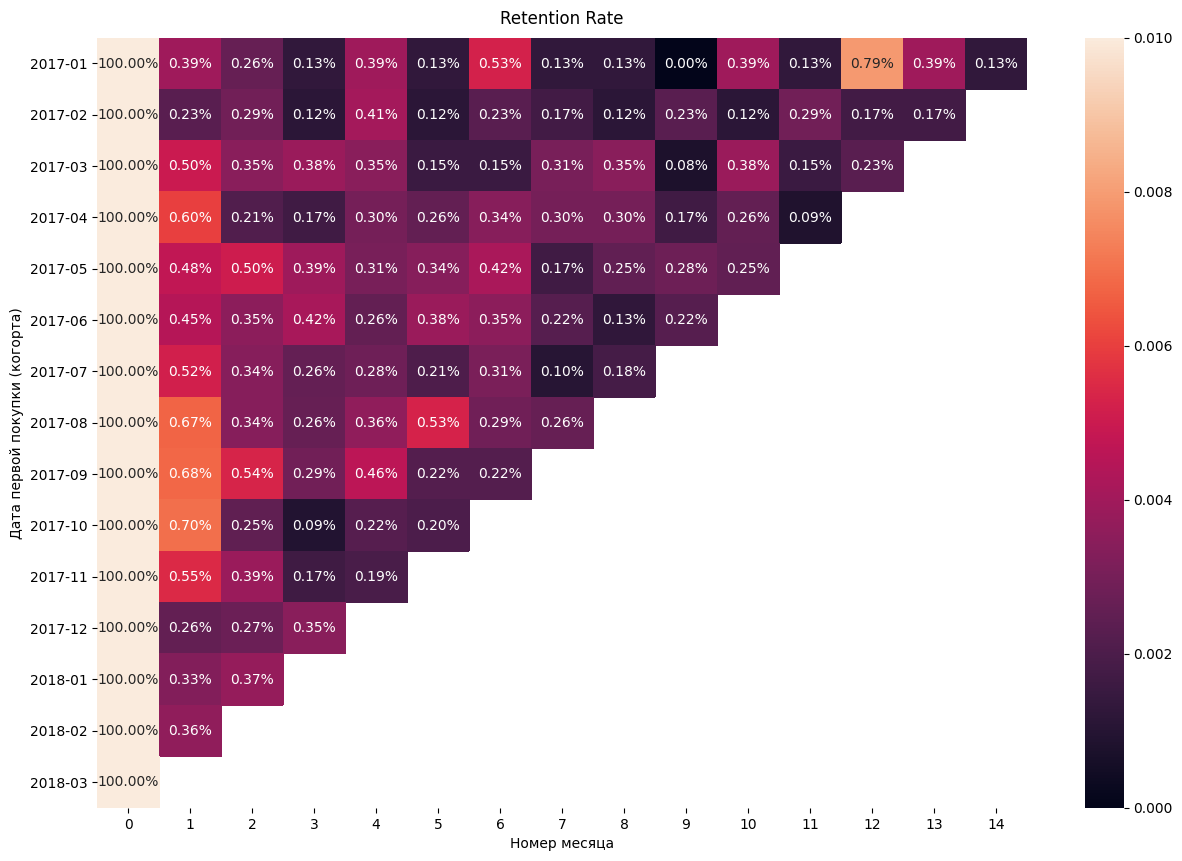

In [88]:
# ВИЗУАЛИЗАЦИЯ корогортного анализа Retantion rate (с порядковыми номерами месяцев)

sns.reset_defaults()
plt.figure(figsize=(15,10))
sns.heatmap(df_with_cohort_period, mask=df_with_cohort_period.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.01)
plt.title('Retention Rate', pad=10)
plt.xlabel('Номер месяца')
plt.ylabel('Дата первой покупки (когорта)')
plt.show()

**Вывод**:  
Самый высокий RR на 3-ий месяц имеет когорта с первыми покупками 2017-06 (июнь 2017). Интересно заметить, что за период наблюдений абсолютный максимум RR пришелся на 12 месяц среди клиентов первой когорты (возможно клиентов этой когорты на 
площадке привлекают новогодние предложения и они охотно возвращаются за покупками).

## 3.2 RFM (Recency, Frequency, Monetary) - анализ 

Это метод сегментации клиентов на основе их поведения и покупок для определения степени ценности каждого клиента и создания более таргетированных маркетинговых стратегий. RFM анализ включает в себя разделение клиентов по следующим показателям:

- R — время от последней покупки пользователя до текущей даты;
- F — суммарное количество покупок у пользователя за всё время;
- M — сумма покупок за всё время.

In [89]:
# Обратимся к данным об ОПЛАЧЕННЫХ заказах и клиентах

df_orders_customers_buy.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP



**Примечание**: Поскольку данные архивные => возьмем в качестве текущей даты дату следующую за датой последней покупки в периоде.


In [90]:
# Определим текущую дату в виде метки

now_date = df_orders_customers_buy.order_purchase_timestamp.max() + pd.to_timedelta(1, unit='d')
print(f'Выбранная текущая дата в данных: {str(now_date).split()[0]}')

Выбранная текущая дата в данных: 2018-09-04


In [91]:
# Определим период в днях между текущей датой (now_date) и датой покупки (order_purchase_timestamp)

df_orders_customers_buy['period_buy'] = df_orders_customers_buy.order_purchase_timestamp.apply(lambda x: (now_date - x).days)

In [92]:
# Обратимся к данным об ОПЛАЧЕННЫХ заказах и товарах в них

df_product_buy.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,week_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [93]:
# Определим общую стоимость каждого заказа

orders_price = df_product_buy \
    .groupby('order_id', as_index=False) \
    .agg({'price':'sum'})
orders_price.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [94]:
# RFM-метрики пользователей

df_RFM = df_orders_customers_buy \
    .merge(orders_price, on='order_id') \
    .groupby('customer_unique_id') \
    .agg({'period_buy':'min', 'order_id': 'count', 'price':'sum'}) \
    .rename(columns={'period_buy':'Recency', 'order_id':'Frequency', 'price':'Monetary'})
df_RFM

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
ffff371b4d645b6ecea244b27531430a,573,1,89.90


In [95]:
# Описательная статистика на каждую метрику

df_RFM.describe().round(2)

,Recency,Frequency,Monetary
count,95543.00,95543.00,95543.00
mean,243.99,1.03,141.24
std,153.09,0.21,215.74
min,1.00,1.00,0.00
25%,120.00,1.00,46.49
50%,225.00,1.00,89.00
75%,353.00,1.00,154.00
max,729.00,17.00,13440.00


**Примечание: оптимальным будет разбить каждую метрику на сегменты по квартилям (см. таблицу выше).** <br/> Однако, для метрики Frequency такое разбиение будет некоректным, поэтому для этой метрики введем другой принцип сегментации.

### Сегментация пользователей

Сегментация **RECENCY**

1 - совершали покупки более 353 дней назад (включительно)<br/>
2 - совершали покупки от 225 до 353 дней назад <br/>
3 - совершали покупки от 120 до 225 дней назад <br/>
4 - совершали покупки от 1 до 120 дней назад

Сегментация **FREQUENCY**

1 - совершали одну покупку <br/>
2 - совершали две покупки <br/>
3 - совершали три покупки <br/>
4 - совершали более трех покупок

Сегментация **MONETARY**

1 - общая стоимость заказов до `46.5$` <br/>
2 - общая стоимость заказов от `46.5$` до `89.0$` <br/>
3 - общая стоимость заказов от `89.0$` до `154.0$` <br/>
4 - общая стоимость заказов свыше `154.0$`

In [96]:
# RECENCY сегментация

df_RFM['R'] = pd.qcut(df_RFM.Recency, 4, labels=[4, 3, 2, 1])

In [97]:
# FREQUENCY сегментация

def FSegment(Frequency: pd.Series):
    if Frequency == 1:
        return 1
    elif Frequency == 2:
        return 2
    elif Frequency == 3:
        return 3
    else:
        return 4

df_RFM['F'] = df_RFM.Frequency.apply(FSegment)

In [98]:
# MONETARY сегментация

df_RFM['M'] = pd.qcut(df_RFM.Monetary, 4, labels=[1, 2, 3, 4])

In [99]:
# Распределение метрик

distr_metrics = df_RFM[['R', 'F', 'M']] \
                        .apply(lambda x: x.value_counts(normalize=True).mul(100)) \
                        .reset_index() \
                        .rename(columns={'index': 'segment'})
distr_metrics.round(2)

,segment,R,F,M
0,1,24.94,96.94,25.00
1,2,24.93,2.81,25.04
2,3,24.98,0.20,24.98
3,4,25.14,0.05,24.98


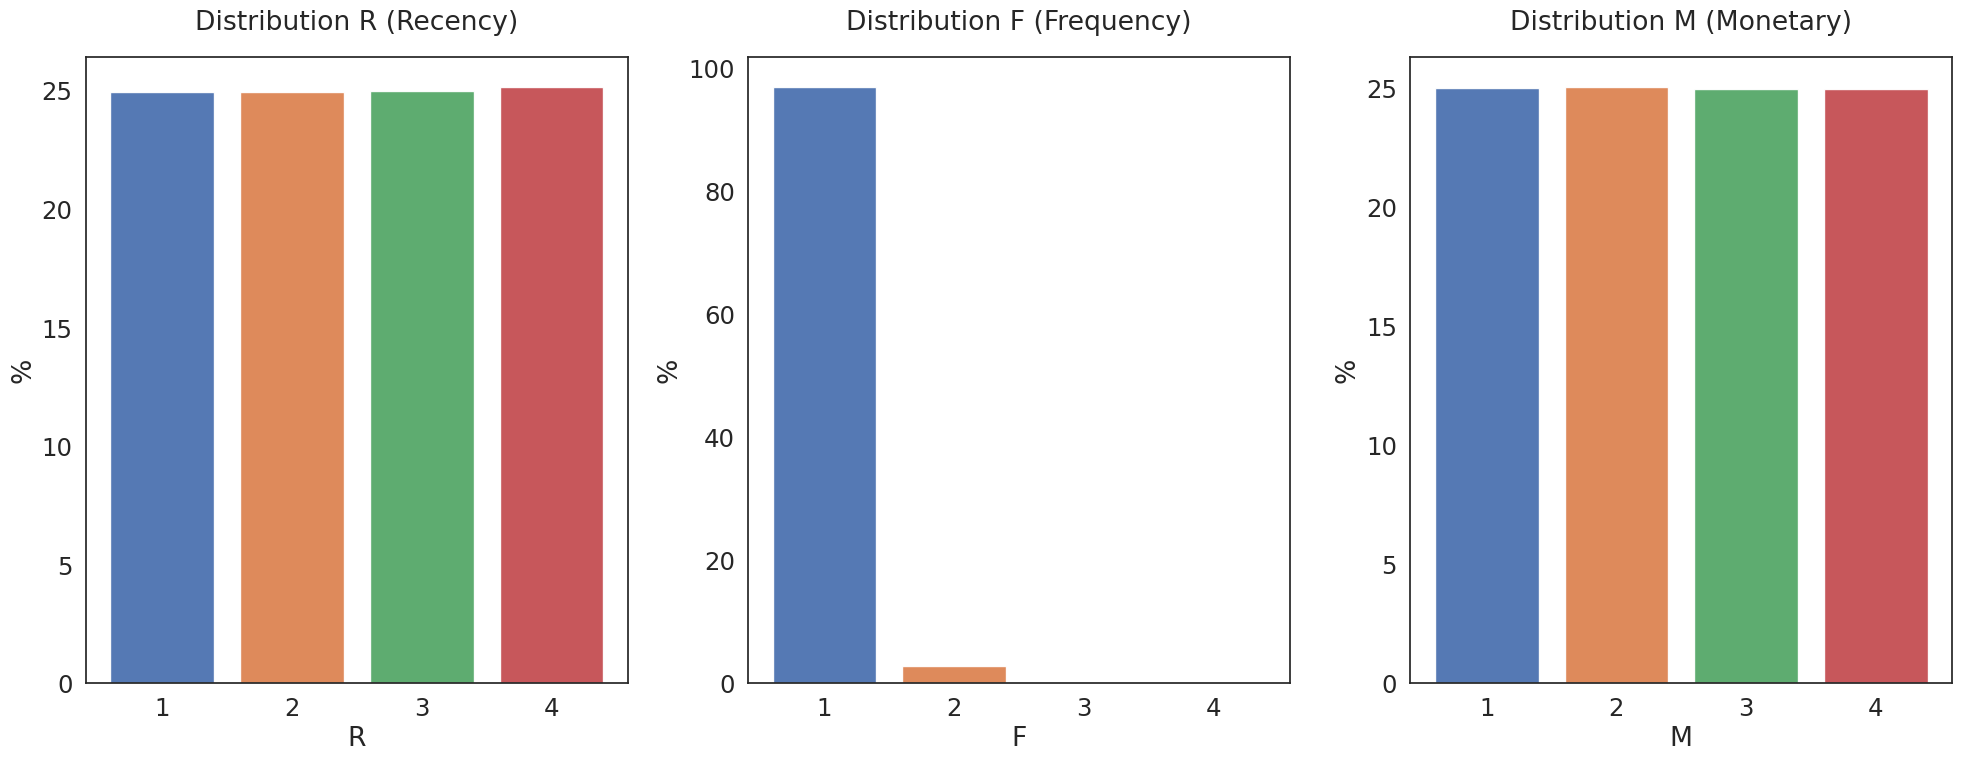

In [100]:
# Выбор стиля
sns.set(font_scale=1.6, style='white')

# Добавление осей графикам
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    
# Названия осей и заголовков
labels = ['R', 'F', 'M']
titles = ['R (Recency)', 'F (Frequency)', 'M (Monetary)']
    
# Построение графиков
for ax, title, label in zip(axs, titles, labels):
    ax.bar(distr_metrics['segment'], distr_metrics[label], color=sns.color_palette(), alpha=0.95)
    ax.set(xlabel=label, ylabel='%')
    ax.set_title(f'Distribution {title}', pad=20)
        
# Отображение графиков
plt.tight_layout()
plt.show()

**Примечание:**

- Недавность покупок распределена равномерно в течении всего периода;

- Доходность пользователей распределена также равномерно, то есть на проекте совершаются как мелкие так и крупные покупки;

По получившимся распределениям убедимся, что сегментация метрик по квартилям произведена успешно => недавность покупок и доходность пользователей равномерно распределены. Стоит заметить, что если при сегментации придерживаться другого принципа (не по квартилям), то полученные распределения с большой долей вероятности будут неравномерны и график покажет наглядные отличия между сегментами.

In [101]:
# Общая оценка клиентов по RFM-метрикам

df_RFM['RFM_score'] = df_RFM['R'].astype('str') + df_RFM['F'].astype('str') + df_RFM['M'].astype('str')
df_RFM.head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,4,214
0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,3,313
00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99,3,1,1,311
00053a61a98854899e70ed204dd4bafe,187,1,382.00,3,1,4,314
0005e1862207bf6ccc02e4228effd9a0,548,1,135.00,1,1,3,113


In [102]:
# Итого общих оценок пользователей (максимум 4^(3) = 64) 

df_RFM.RFM_score.nunique()

51

In [103]:
# Посмотрим на распредление количества покупок по RFM-сегментам 

distr_Frequency = df_RFM.groupby('RFM_score', as_index=False) \
                        .agg({'Frequency': lambda x: x.sum() / df_RFM.Frequency.sum() * 100}) \
                        .sort_values('Frequency', ascending=False) \
                        .round(2)
distr_Frequency.reset_index(drop=True).head()

,RFM_score,Frequency
0,111,6.25
1,212,6.13
2,313,6.04
3,413,6.01
4,411,5.98


In [104]:
print(f"На первые 15 RFM-сегментов приходится \
{distr_Frequency.query('Frequency > 1').Frequency.sum():.2f} % от общего объема покупок")

На первые 15 RFM-сегментов приходится 93.76 % от общего объема покупок


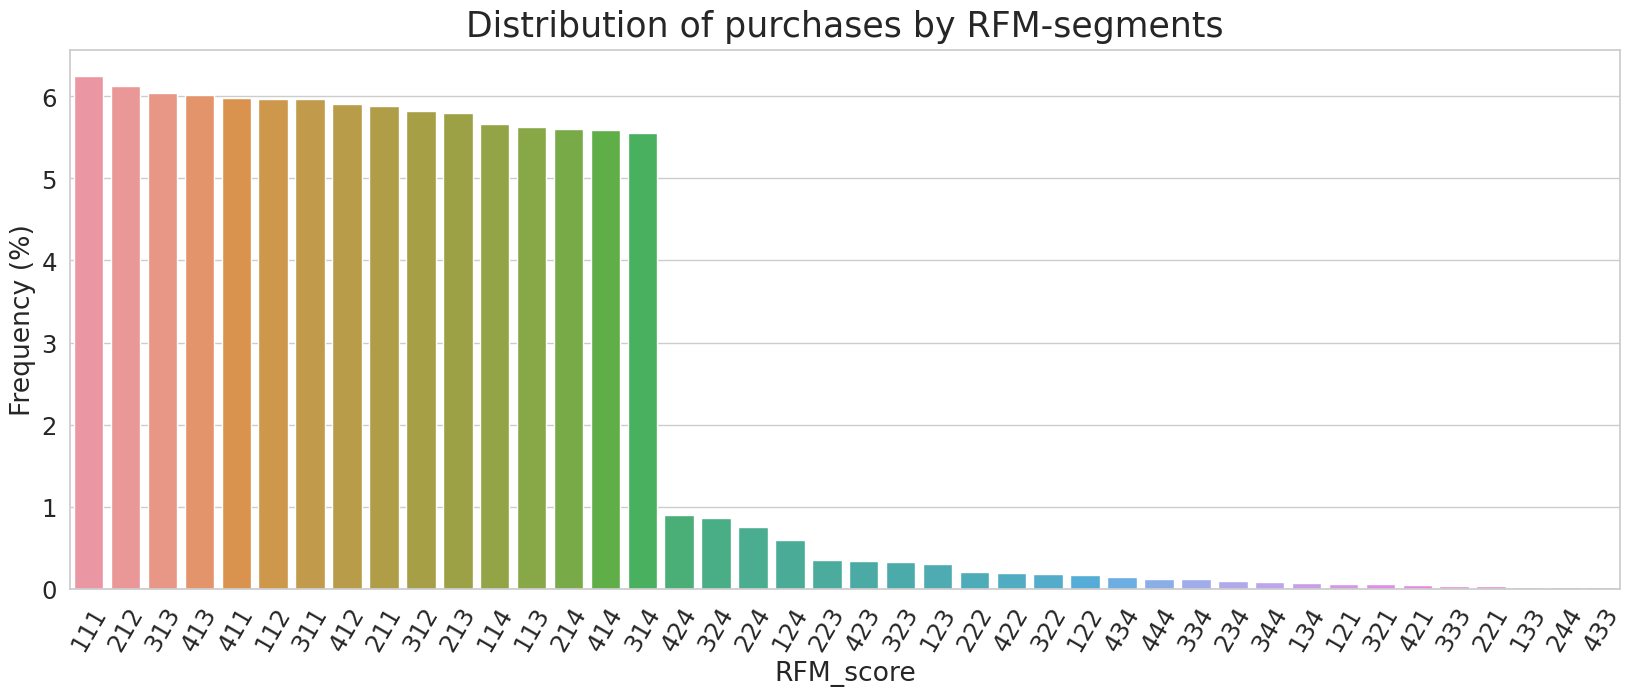

In [105]:
plt.figure(figsize=(20, 7))
sns.set(font_scale=1.6, style='whitegrid')
sns.barplot(data=distr_Frequency.query('Frequency > 0.01'), x='RFM_score', y='Frequency')
plt.xticks(rotation=60)
plt.ylabel('Frequency (%)')
plt.title('Distribution of purchases by RFM-segments', pad=10, fontsize=25)
plt.show()

**Примечание:** 
- Большую часть покупок за все время (~94%) совершили пользовали с frequency = 1;
- Максимальное число покупок совершили пользователи `Сегмента 111` (recency=1, frequency=1, monetary=1). Для этого сегмента характерно совершение одной покупки более 353 дней назад общей стоимостью до 46.5 долларов.

In [106]:
# Посмотрим на распредление дохода по RFM-сегментам 

distr_Monetary = df_RFM.groupby('RFM_score', as_index=False) \
                       .agg({'Monetary': lambda x: x.sum() / df_RFM.Monetary.sum() * 100}) \
                       .sort_values('Monetary', ascending=False) \
                       .round(2)
distr_Monetary.reset_index(drop=True).head()

,RFM_score,Monetary
0,114,14.97
1,414,14.81
2,214,14.16
3,314,14.02
4,313,5.27


In [107]:
print(f"На первые 4 RFM-сегмента приходится \
{distr_Monetary.query('Monetary > 10').Monetary.sum():.2f} % от общего дохода бизнеса")

На первые 4 RFM-сегмента приходится 57.96 % от общего дохода бизнеса


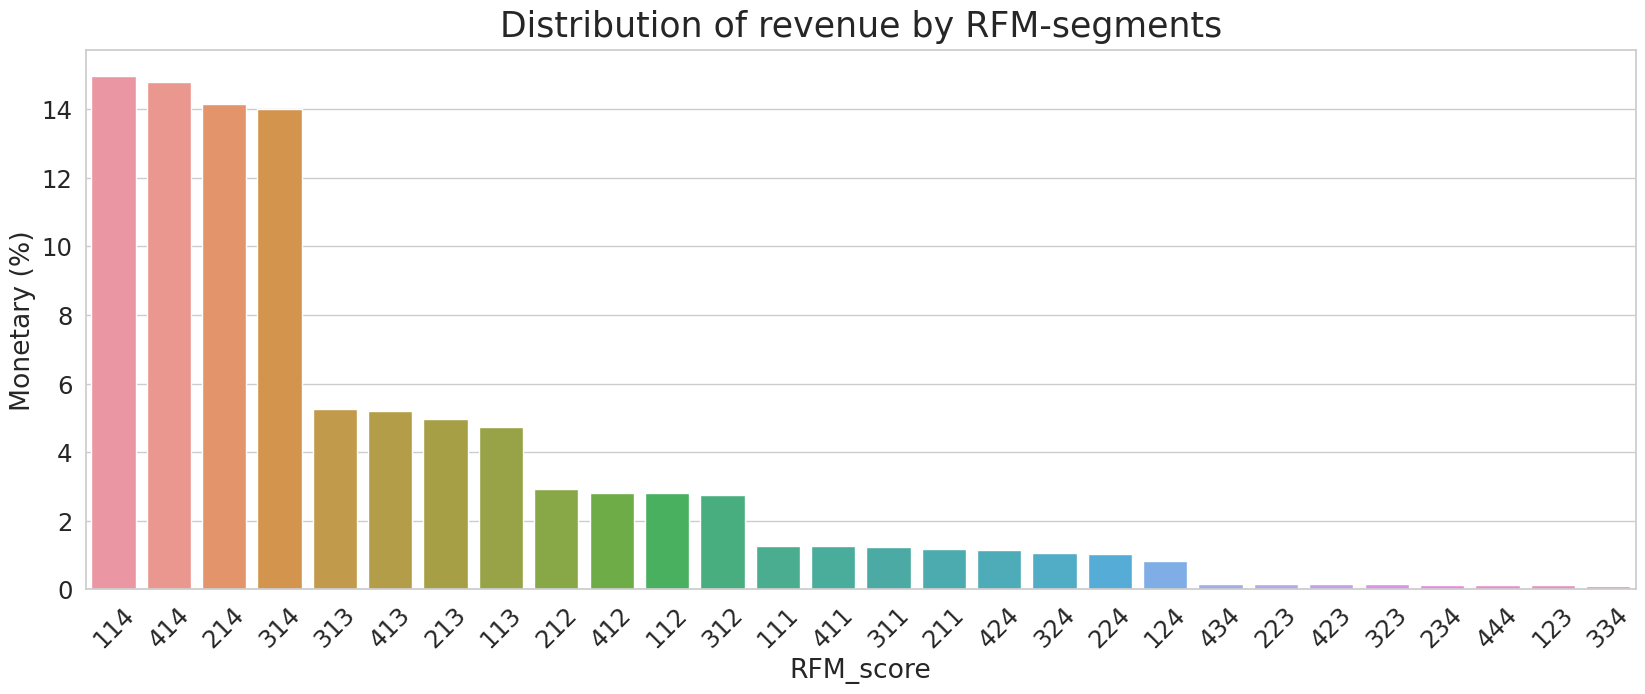

In [108]:
plt.figure(figsize=(20, 7))
sns.set(font_scale=1.6, style='whitegrid')
sns.barplot(data=distr_Monetary.query('Monetary > 0.1'), x='RFM_score', y='Monetary')
plt.title('Distribution of revenue by RFM-segments', pad=10, fontsize=25)
plt.ylabel('Monetary (%)')
plt.xticks(rotation=45)
plt.show()

**Примечание:** Основную прибыль (~58%) приносят пользователи следующих сегментов:
- `Сегмент 114` (recency=1, frequency=1, monetary=4). Для этого сегмента характерно совершение одной покупки более 353 дней назад общей стоимостью свыше 154 долларов.
- `Сегмент 414` (recency=4, frequency=1, monetary=4). Для этого сегмента характерно совершение одной покупки не более 120 дней назад общей стоимостью свыше 154 долларов.
- `Сегмент 214` (recency=2, frequency=1, monetary=4). Для этого сегмента характерно совершение одной покупки от 225 до 353 дней назад стоимостью свыше 154 долларов.
- `Сегмент 314` (recency=3, frequency=1, monetary=4). Для этого сегмента характерно совершение одной покупки от 120 до 225 дней назад общей стоимостью свыше 154 долларов.

Следовательно, для всех рассмотренных выше сегментов приносящих основную прибыль проекту характерно совершение одноразовых покупок относительно высокой стоимости.

### Сегментация пользователей по категориям

Разделим всех пользователей по сочетанию RF-метрик на следующие категории:

 - **`hibernating`** ==  Делал мало заказов и покупка была давно **(потенциально потеряны)**; <br/>

 - **`can\'t loose`**        == Делал много заказов, но давно не возвращался **(нельзя потерять)**; <br/>

 - **`need attention`**      == Делал мало заказов относительно недавно **(нужно активизировать)**; <br/>

 - **`loyal customers`**     == Делал много заказов относительно недавно **(лояльные пользователи)**; <br/>

 - **`new customers`**       == Делал один заказ совсем недавно **(новые пользователи)**; <br/>

 - **`potential loyalists`** == Делал несколько заказов совсем недавно **(потенциально лояльные клиенты)**; <br/>

 - **`best customers`**      == Делал много заказов совсем недавно **(лучшие клиенты).** <br/>

In [109]:
# Создадим матрицу RF-сегментов

segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'can\'t loose',
    r'3[1-2]': 'need attention',
    r'3[3-4]': 'loyal customers',
    r'41': 'new customers',
    r'42': 'potential loyalists',
    r'4[3-4]': 'best customers'
}
df_RFM['Segment'] = df_RFM['R'].astype('str') + df_RFM['F'].astype('str')
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)

RFM_table = df_RFM.pivot_table(index='R', columns='F', values='Segment', aggfunc='first').T[[1, 2, 3, 4]]
RFM_table

R,1,2,3,4
F,,,,
1,hibernating,hibernating,need attention,new customers
2,hibernating,hibernating,need attention,potential loyalists
3,can't loose,can't loose,loyal customers,best customers
4,can't loose,can't loose,loyal customers,best customers


**Примечание:** визуализируем полученную RF-матрицу с помощью seaborn.heatmap() для наглядности распределения категорий

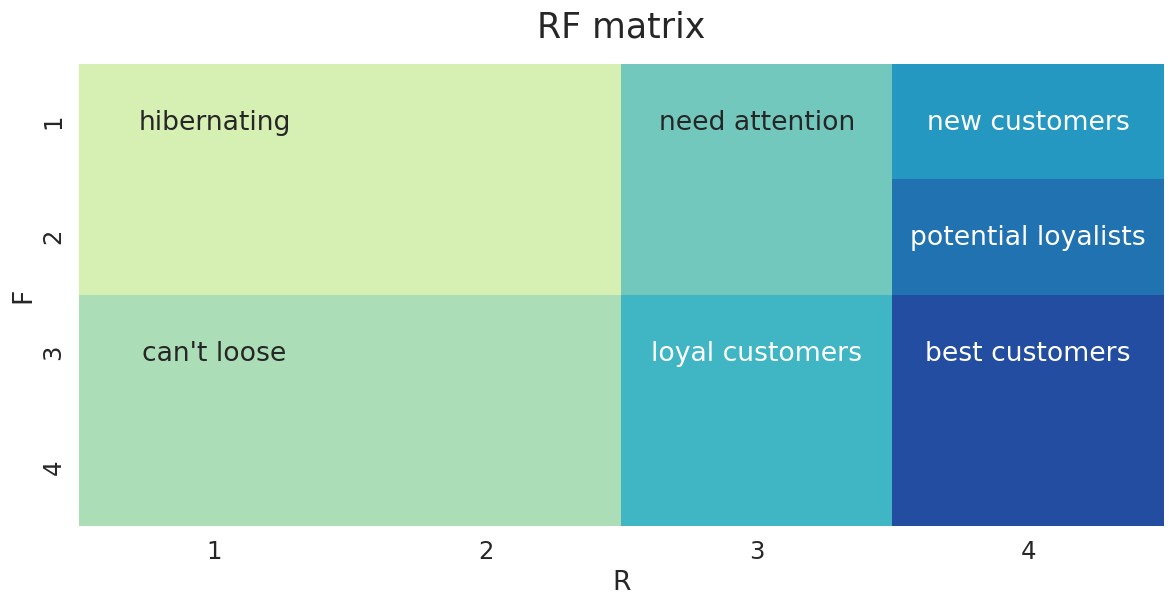

In [110]:
plt.figure(figsize=(14, 6))

segment_values = pd.DataFrame({'1': [1000, 1000, 1500, 1500],
                               '2': [1000, 1000, 1500, 1500],
                               '3': [2000, 2000, 2500, 2500],
                               '4': [3000, 3500, 4000, 4000]},
                              index=[   1,    2,    3,    4])

segment_names = np.array([["hibernating", "",  "need attention",       "new customers"],
                         [           "", "",                "", "potential loyalists"],
                         ["can't loose", "", "loyal customers",      "best customers"],
                         [           "", "",                "",                   ""]])

RFmatrix = sns.heatmap(segment_values, annot=segment_names, fmt='', cmap='YlGnBu', cbar=False, vmin=0, vmax=5000)
plt.title('RF matrix', pad=20, fontsize=25)
plt.xlabel('R')
plt.ylabel('F')
plt.show()

In [111]:
# Определим долю каждой категории в общем количестве

df_diff_seg = df_RFM.Segment \
                    .value_counts(normalize=True) \
                    .mul(100) \
                    .to_frame(name='Percent') \
                    .round(2) \
                    .reset_index() \
                    .rename(columns={'index':'Segment'})
df_diff_seg

,Segment,Percent
0,hibernating,49.78
1,need attention,24.91
2,new customers,24.29
3,potential loyalists,0.77
4,can't loose,0.09
5,best customers,0.08
6,loyal customers,0.07


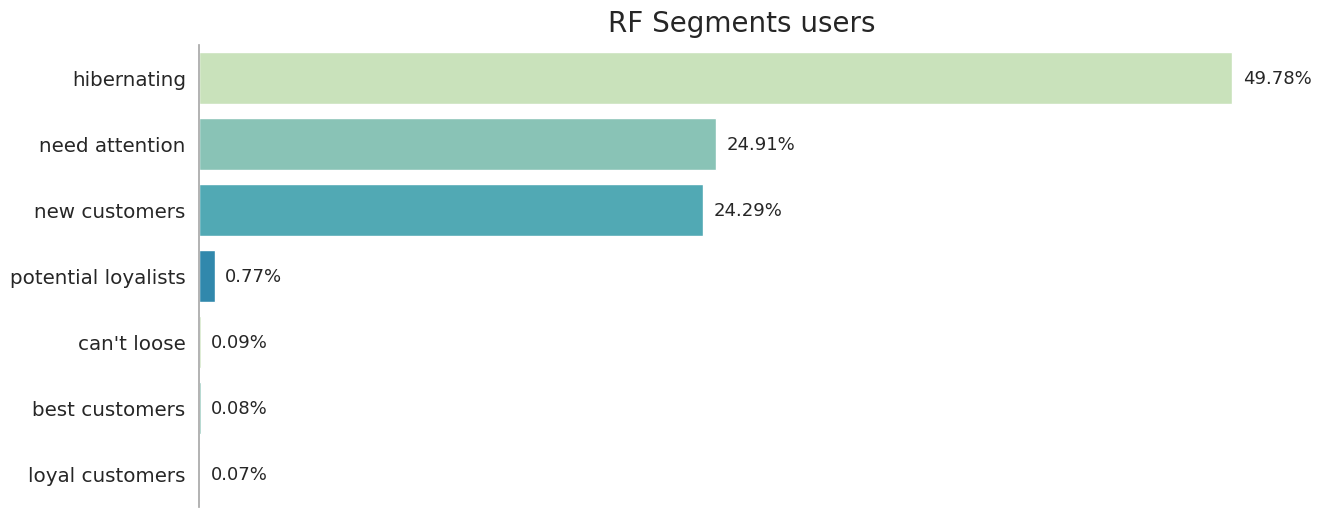

In [112]:
# Распредление пользователей по категориям

plt.figure(figsize=(14, 6))
sns.set(font_scale=1.3, style='whitegrid')
ax = sns.barplot(x=df_diff_seg.Percent, y=df_diff_seg.Segment, orient='h', palette=['#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0'])
ax.set(xlabel='', ylabel='')

sns.despine()
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#a9a9a9')
plt.title('RF Segments users', pad=10, fontsize=20)
plt.xticks([])

for index, value in enumerate(df_diff_seg.Percent):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=13)
plt.show()

**Вывод по RFM-анализу:**

1) Около ~50 % клиентов не совершали покупок более 225 дней, попадая в категорию (hibernating). Это указывает на значительное количество клиентов, которые потенциально потеряны для бизнеса;

2) Около ~25% клиентов совершали покупки относительно недавно (need attention). Этих клиентов необходимо активизировать и удержать;

3) Не более ~0.15 % клиентов можно отнести к лояльным (best customers) и (loyal customers). Эти клиенты совершали покупки недавно и делают это часто, данная категория требует особого внимания;

4) До ~1 % потенциально можно увеличить активную аудиторию, если перевести клиентов potential loyalists к лояльным.

**Анализируемый e-commerce проект имеет малое количество лояльных покупателей, его основная база это новые клиенты, которые приходят стабильно и совершают в большинстве случаев не более одной покупки. Проект хорошо справляется с привличением новых клиентов, но требуется активно работать над удержанием.**